In [1]:
using Pkg
using Plots
using Statistics
using LinearAlgebra
using ForwardDiff
import PyPlot as py
using FFTW
using SpecialFunctions
using ColorSchemes
using PyCall
using DelimitedFiles
using Images
using SparseArrays
using BenchmarkTools
using DelimitedFiles
using JLD
include("..//source//tikhonov2d_iterative.jl");
include("..//source//dericheFilter.jl");

# Frequency Plots

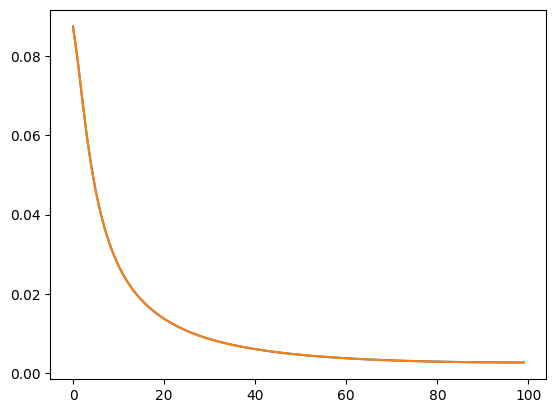

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005AC51D60>

In [4]:
lx = 80
ly = 30

t = zeros(100)
for i =0:99
    t[i+1] = Jfun(lx,ly,pi*i/100)
end


t = zeros(100)
for i =1:100
    t[i] = Jfun(lx,ly,pi*i/100)
end
py.plot(t)
py.plot(gaussianKernelFitPlot(lx, ly, 20; linOpt=1))

# Tables

In [392]:
#err2 = load("err2.jld","data");
err1 = load("data\\err1.jld","data");
err2 = load("data\\err2.jld","data");
psnr = load("data\\psnr.jld","data");

ierr1 = load("improv_err1.jld","data");
ierr2 = load("improv_err2.jld","data");
ipsnr = load("improv_psnr.jld","data");

In [ ]:
argmin(psnr

In [416]:
g = 3
@show mean(ipsnr[g,:,:,:])
@show std(ipsnr[g,:,:,:])
@show minimum(ipsnr[g,:,:,:])

mean(ipsnr[g, :, :, :]) = 59.30268845888608
std(ipsnr[g, :, :, :]) = 3.8060135575188965
minimum(ipsnr[g, :, :, :]) = 48.277102376399895


48.277102376399895

In [417]:
g = 3
@show mean(ierr1[g,:,:,:])*100
@show std(ierr1[g,:,:,:])*100
@show maximum(ierr1[g,:,:,:])*100;

mean(ierr1[g, :, :, :]) * 100 = 0.2458508469647094
std(ierr1[g, :, :, :]) * 100 = 0.12325928902558497
maximum(ierr1[g, :, :, :]) * 100 = 0.7050463678161314


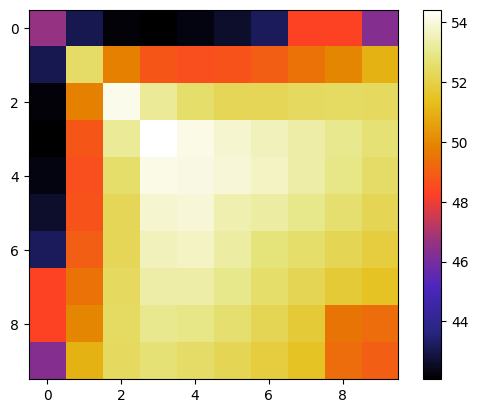

PyObject <matplotlib.colorbar.Colorbar object at 0x000000000DE89430>

In [400]:
py.imshow(minimum(psnr; dims=4)[2,:,:], cmap=:CMRmap);
py.colorbar()

# Routine to filter RGB image with FFT

In [5]:
function fftfilter2D(img,lx,ly)
    channels, N, M = size(img)
    N2 = 2*N; #increase image size to avoid circular filtering
    M2 = 2*M
    
    g = zeros(ComplexF64, channels, N2, M2)
    g[:,1:N,1:M] = img #embbed image
    
    g = fft(g)
    for i =1:N2, j=1:M2
        w = 2*pi*(i-1)/N2
        xi = 2*pi*(j-1)/M2
        g[:,i,j] = g[:,i,j]/(1+2*lx*(1-cos(w))+2*ly*(1-cos(xi)))
    end
    
    return clamp01.(real.(ifft(g)))[:,1:N,1:M] #clamp values in [0,1]
end;


# Impulse Response

In [6]:
@time begin 
    A, Sx, Sy, c0  =  gaussianKernelFit(1,100,7; linOpt = 0);
    improve(A,Sx,Sy,c0,1,100);
end;

  2.625410 seconds (2.30 M allocations: 125.250 MiB, 2.35% gc time, 92.73% compilation time)


assess_psnr(fftRes, dericheRes, 1) = 104.64693118664343
norm(fftRes - dericheRes) / norm(fftRes) = 0.015005404790635803
norm(fftRes - dericheRes, 1) / norm(fftRes, 1) = 0.015163301170002986


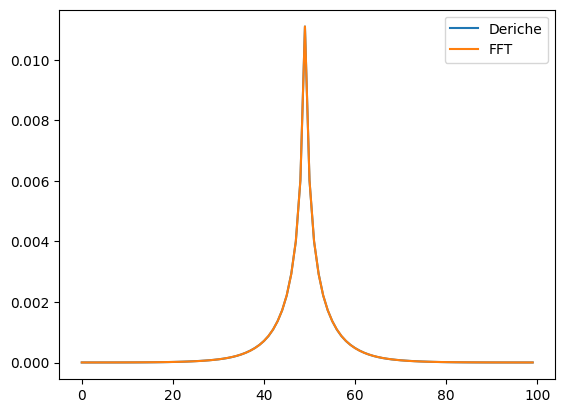

PyObject <matplotlib.legend.Legend object at 0x000000005CC82BE0>

In [21]:
N = 100
p = N÷2
L = N
nGaussian =5
img = zeros(1,N,N)
img[1,p, p] = 1
lx = 70
ly = 40
fftRes = fftfilter2D(img,lx,ly)[1,1:L,1:L];
dericheRes =  recursiveFilter2D(img,lx,ly, nGaussian)[1,1:L,1:L];
dericheRes =  recursiveFilter2Doptimize(img,lx,ly, nGaussian)[1,1:L,1:L]

@show assess_psnr(fftRes,dericheRes,1)
@show norm(fftRes-dericheRes)/norm(fftRes)
@show norm(fftRes-dericheRes,1)/norm(fftRes,1)

#plot(dericheRes[p,:], label = "deriche")
#plot!(fftRes[p,:], label="fft")
#py.plot(dericheRes[p,:] .+ 1e-6, yscale = :log10, label = "deriche")

py.plot(dericheRes[p,:] .+ 1e-6)
py.plot(fftRes[p,:] .+ 1e-6)
py.legend(["Deriche","FFT"])

In [22]:
norm(dericheRes[:,p] - fftRes[:,p])/norm(fftRes[:,p])

0.0020351076548622195

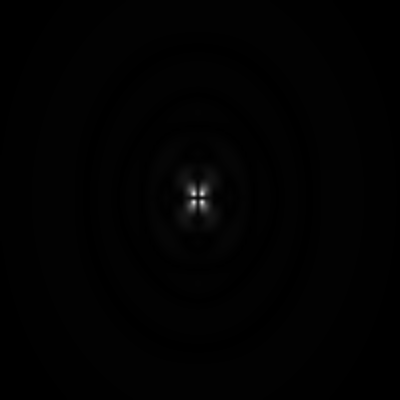

In [23]:
imresize(
colorview(Gray,imadjustintensity(abs.(fftRes-dericheRes))), ratio=4.0)

# Single Image Comparison

  6.428001 seconds (936.52 k allocations: 3.224 GiB, 13.06% gc time, 4.76% compilation time)
rel error: 0.05202063835049343
psnr: 32.86460575995297
extrema(-13.90060178621375, 0.6108344418080464)


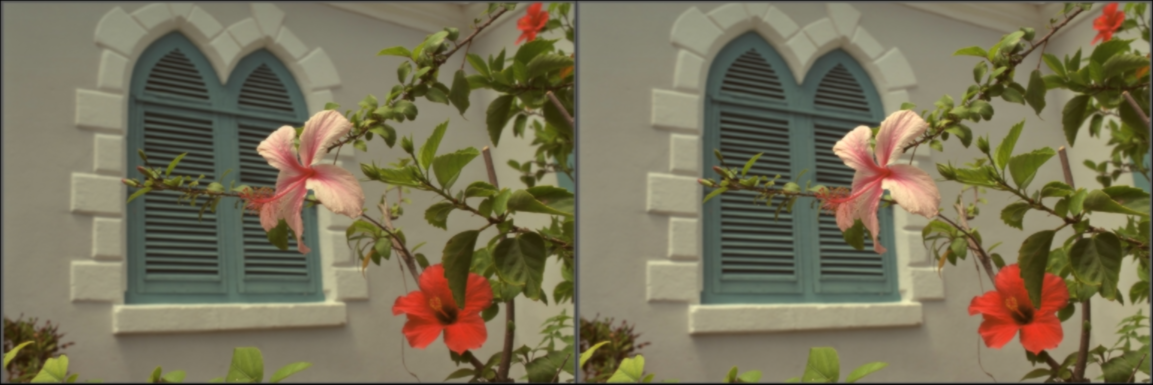

In [24]:
lx = 2;
ly = 3;
nGaussian =5;

img = load("../data/kodak7.jpg") .|>RGB{Float64}  |>channelview

fftFiltered = fftfilter2D(img,lx,ly)

@time gaussianFiltered = 
        recursiveFilter2D(img, lx,ly, nGaussian, linOpt=1)

im1 = colorview(RGB, fftFiltered)
im2 = colorview(RGB, gaussianFiltered);

print("rel error: ",norm(fftFiltered .- gaussianFiltered)/norm(fftFiltered),"\n")
print("psnr: ",assess_psnr(fftFiltered,gaussianFiltered,1),"\n")
print("extrema", extrema(fftFiltered-gaussianFiltered).*255, "\n")
colorview(RGB,hcat(im1,im2))

In [25]:
save("../output/compareFFT_100_40.png",colorview(RGB,hcat(im1,im2)))

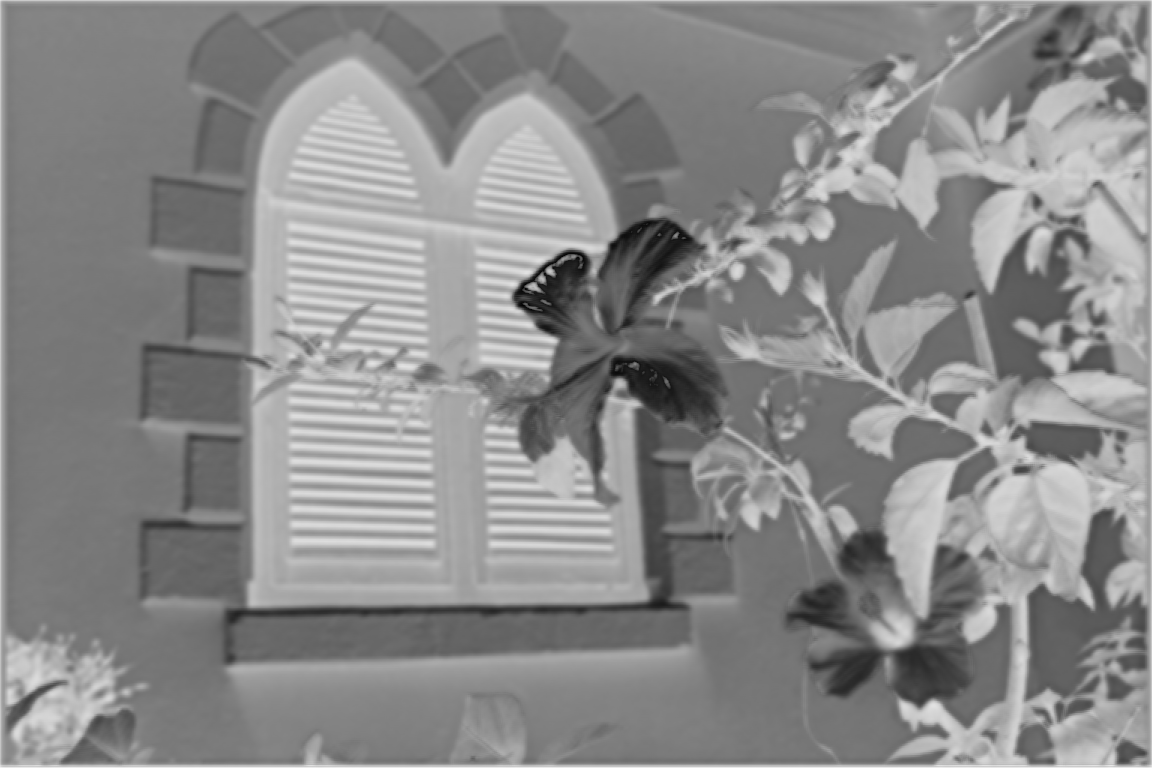

In [26]:
colorview(Gray,imadjustintensity(fftFiltered-gaussianFiltered)[1,:,:])

In [27]:
data = readdir("../data/"; join=true)
max_ngaussian = 7
min_ngaussian = 4
numL = 10
nimgs = length(data)
lambdas = LinRange(10,100,numL)

errs1 = zeros(max_ngaussian-min_ngaussian,numL,numL,nimgs)
errs2 = zeros(max_ngaussian-min_ngaussian,numL,numL,nimgs)
psnrs = zeros(max_ngaussian-min_ngaussian,numL,numL,nimgs) .+ 1e5

for g = 1: max_ngaussian-min_ngaussian
    
    ng = g + min_ngaussian
    
    for i = 1:numL, j= 1:i
        print("numgaussians = ", ng,"\n")
        lx = lambdas[i]
        ly = lambdas[j]
        ind = 1

        for path in data
            img = load(path)|>channelview
            fftFiltered = fftfilter2D(img,lx,ly)
            gaussianFiltered = recursiveFilter2D(img, lx,ly, ng)

            se = norm(fftFiltered - gaussianFiltered,2) #squared error
            mse = se/length(img) #mean squared error

            norm1 = norm(fftFiltered - gaussianFiltered,1)/norm(fftFiltered,1) #relative l1 error
            norm2 = se/norm(fftFiltered,2) #relative l2 error
            psnrval = assess_psnr(fftFiltered, gaussianFiltered,1)

            errs1[g,i,j,ind] = norm1
            errs2[g,i,j,ind] = norm2
            psnrs[g,i,j,ind] = psnrval

            ind +=1
        end

    end

end



numgaussians = 5
numgaussians = 5

LoadError: InterruptException:

In [67]:
#save("err1.jld", "data", errs1)
#save("err2.jld", "data", errs2)
#save("psnr.jld", "data", psnrs)

In [299]:
err1 = load("err1.jld","data")
err2 = load("err2.jld","data")
err3 = load("psnr.jld","data");

In [312]:
err1m = mean(err1,dims=4)
std(err1m[2,:,:])

0.005031546681193668

## Fill transposes

In [36]:
for g = 1: max_ngaussian-min_ngaussian
    ng = g + min_ngaussian
    
    for i = 1:numL, j= 1:i, k =1:nimgs
        errs1[g,j,i,k] = errs1[g,i,j,k]
        errs2[g,j,i,k] = errs2[g,i,j,k]
        psnrs[g,j,i,k] = psnrs[g,i,j,k]
    end

end

In [73]:
maximum(errs1[3,:,:,:])

0.04138819423096924

In [72]:
maximum(errs2[4,:,:,:])

0.04304323111427657

In [70]:
minimum(psnrs[4,:,:,:])

48.66907776252056

# Using Optimizer

In [7]:
#Exact kernel from ift
function extractKernel2d(lx,ly,n,N)
    g = zeros(ComplexF64,n,n)
    for i =1:n, j=1:n
        w = 2*pi*(i-1)/n
        xi = 2*pi*(j-1)/n
        g[i,j] = 1/(1+2*lx*(1-cos(w))+2*ly*(1-cos(xi)))#*exp(im*w)*exp(im*xi)
    end
     g = real.(FFTW.ifft(g))
    return g[1:N,1:N]
end;

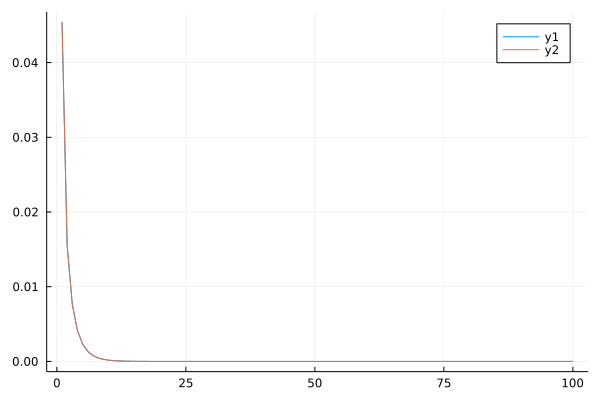

In [35]:
plot(get1DspatialKernelDiag(10,10,100))
plot!(extractKernel2d(10,10,1000,100) |>diag)

In [433]:
lx = 200
ly = 200
ng = 10
@time begin
    A, Sx, Sy, c0 = gaussianKernelFit(lx, ly, ng; linOpt=0)
    A, Sx, Sy, c0 = improve(A, Sx, Sy, c0,10,10)
end;

  0.233824 seconds (933 allocations: 51.375 KiB)


## Single image

  4.409020 seconds (593.82 k allocations: 3.033 GiB, 27.99% gc time)
assess_psnr(fftFiltered, gaussianFiltered, 1) = 51.34283056327465


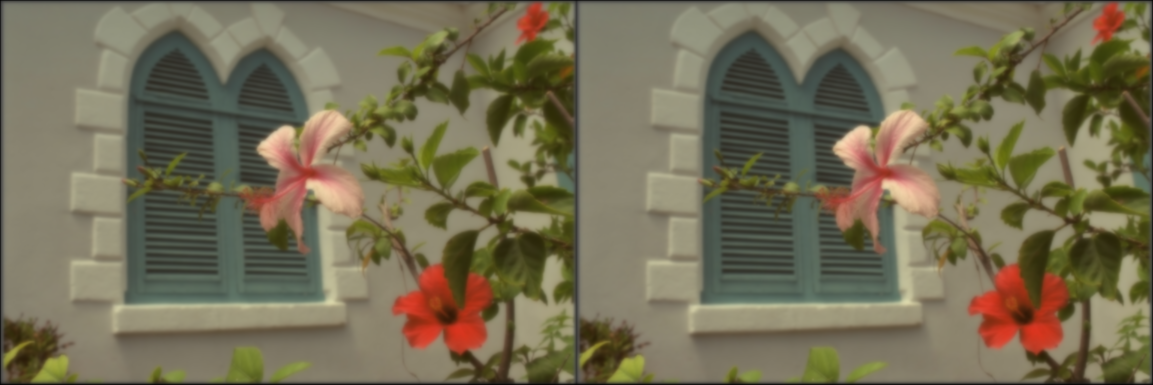

In [436]:
lx = 10
ly = 10
nGaussian = 6;

img = load("../data/kodak7.jpg") |>channelview

fftFiltered = fftfilter2D(img,lx,ly)
@time gaussianFiltered = recursiveFilter2Doptimize(img, lx,ly, nGaussian)
im1 = colorview(RGB, fftFiltered)
im2 = colorview(RGB, gaussianFiltered);

@show assess_psnr(fftFiltered,gaussianFiltered,1)

colorview(RGB,hcat(im1,im2))

In [435]:
# Relative error:
norm(fftFiltered .- gaussianFiltered)/norm(fftFiltered)

0.01110604718756151

## Multiple images

In [98]:
data = readdir("../data/"; join=true)
max_ngaussian = 6
min_ngaussian = 3
numL = 10
nimgs = length(data)
lambdas = LinRange(10,100,numL)

errs1 = zeros(max_ngaussian-min_ngaussian,numL,numL,nimgs)
errs2 = zeros(max_ngaussian-min_ngaussian,numL,numL,nimgs)
psnrs = zeros(max_ngaussian-min_ngaussian,numL,numL,nimgs) .+ 1e5

for g = 1: max_ngaussian-min_ngaussian
    
    ng = g + min_ngaussian
    print("numgaussians = ", ng,"\n")
    
    for i = 1:numL, j= 1:i
        lx = lambdas[i]
        ly = lambdas[j]
        ind = 1

        for path in data
            img = load(path)|>channelview
            fftFiltered = fftfilter2D(img,lx,ly)
            gaussianFiltered = recursiveFilter2Doptimize(img, lx,ly, ng)

            se = norm(fftFiltered - gaussianFiltered,2) #squared error
            mse = se/length(img) #mean squared error

            norm1 = norm(fftFiltered - gaussianFiltered,1)/norm(fftFiltered,1) #relative l1 error
            norm2 = se/norm(fftFiltered,2) #relative l2 error
            psnrval = 10*log(10,1/mse)

            errs1[g,i,j,ind] = norm1
            errs2[g,i,j,ind] = norm2
            psnrs[g,i,j,ind] = psnrval

            ind +=1
        end

    end

end


numgaussians = 4
numgaussians = 5
numgaussians = 6


In [114]:
minimum(psnrs[2,:,:,:])

53.04222362952529

In [99]:
save("improvederr1.jld", "data", errs1)
save("improvederr2.jld", "data", errs2)
save("improvedpsnr.jld", "data", psnrs)

# Compute (ly,lx) pairs for analysis

In [160]:
errs1 = load("improvederr1.jld","data");
errs2 = load("improvederr2.jld","data");
psnrs = load("improvedpsnr.jld","data");

In [125]:
errs1 = load("verr1.jld","data");
errs2 = load("verr2.jld","data");
psnrs = load("vpsnr.jld","data");

In [162]:
for g = 1: 3
    for i = 1:10, j= 1:i, k=1:10
        errs1[g,j,i,k] = errs1[g,i,j,k]
        errs2[g,j,i,k] = errs2[g,i,j,k]
        psnrs[g,j,i,k] = psnrs[g,i,j,k]
    end
end

In [189]:
mean(psnrs[3,:,:,:])

56.70458901521751

In [190]:
std(psnrs[3,:,:,:])

1.0522843875588894

# Fwd Bwd impulse

In [28]:
function response(s,N,p)
    I = zeros(N)
    
    params =  dericheCoefficients(s)
    eta = params[1:4]
    d = params[5:8]
    n = params[9:12]
    res = zeros(N)
    res[p] = 1 
    
    mult = (1+d[1]+d[2]+d[3]+d[4])
    #fwd
    res[1] = res[1]*mult
    res[2] = res[2]*mult -d[1]*res[1]
    res[3] = res[3]*mult -d[1]*res[2] - d[2]*res[1]
    res[4] = res[4]*mult -d[1]*res[3] - d[2]*res[2] - d[3]*res[1]
    for i = 5:N
        res[i] = res[i]*mult - d[1]*res[i-1] - d[2]*res[i-2] - d[3]*res[i-3] - d[4]*res[i-4]
    end
       
    
    #bwd
    for i = N-4:-1:1
        res[i] = res[i]*mult - d[1]*res[i+1] - d[2]*res[i+2] - d[3]*res[i+3] - d[4]*res[i+4]
    end
           
    return res
end


function analyticImpulse(s,N,p)
    params = dericheCoefficients(s)
    d = params[5:8]
    psi = psi_(d)
    res = zeros(N)
    for i =1:N
        res[i] = psi(i-p)
    end
    return res
end

analyticImpulse (generic function with 1 method)

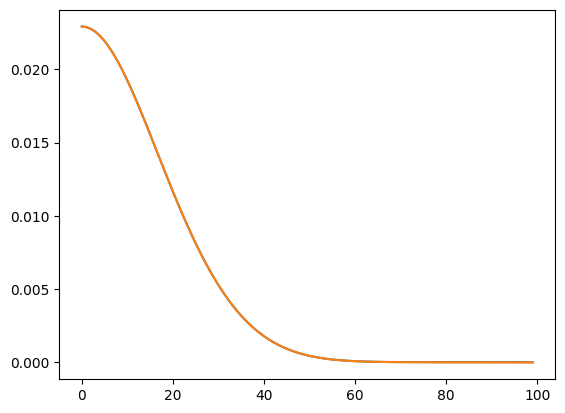

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005D04B9D0>

In [30]:
s=20
N=100
p = 1
py.plot(response(s,N,p))
py.plot(analyticImpulse(s,N,p))

In [635]:
using LinearAlgebra
using SparseArrays


In [639]:
function ForwardDiffOperators( siz::NTuple{N,Int} ) where N
    ntuple(i->begin
        M = siz[i]
        B = prod(siz[1:i-1])   # Note that prod([]) == 1
        A = prod(siz[i+1:end]) # Note that prod([]) == 1

        D = spdiagm(0 => ones(Int,M), -1 => -ones(Int,M-1), M-1 => [-1])
        D = kron(sparse(1I,(A,A)), D)
        D = kron(D, sparse(1I,(B,B)))
    end, N)
end;

ForwardDiffOperators( M::Int ) = ForwardDiffOperators( (M,) )[1];

In [648]:
function choleskysolve(img, lx, ly)
    Dy, Dx = ForwardDiffOperators( size(img) )
    A = I + lx * Dx'Dx + ly * Dy'Dy
    @time sol = cholesky(A) \ vec(img)
    return sol
end;

In [650]:
choleskysolve(img[1,:,:],lx,ly);

  8.318491 seconds (74 allocations: 1.019 GiB, 0.03% gc time)


In [272]:
import AlgebraicMultigrid as amg

In [667]:
function amgsolve(img, lx, ly)
    Dy, Dx = ForwardDiffOperators( size(img) )
    A = I + lx * Dx'Dx + ly * Dy'Dy
    b = vec(img)
    @time sol = amg.solve(A, b, amg.RugeStubenAMG(), maxiter = 10, abstol = 1e-6)
    return sol
end;

In [677]:
lx = 30.00
ly = 30.00

res = copy(img)
res[1,:,:] = amgsolve(img[1,:,:],lx,ly);
res[2,:,:] = amgsolve(img[2,:,:],lx,ly);
res[3,:,:] = amgsolve(img[3,:,:],lx,ly);

  4.335506 seconds (886 allocations: 1.862 GiB, 12.86% gc time)
  6.492567 seconds (886 allocations: 1.862 GiB, 44.60% gc time)
  4.630974 seconds (886 allocations: 1.862 GiB, 19.95% gc time)


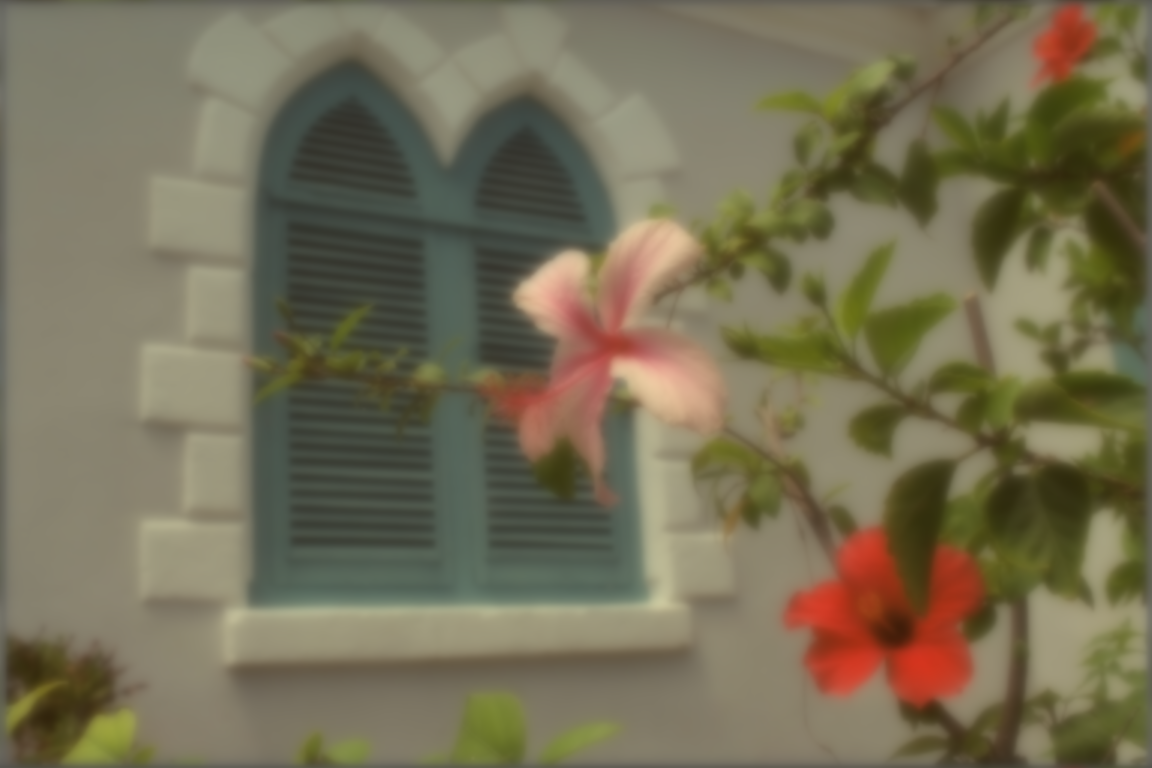

In [678]:
colorview(RGB, res)

# Plot C++ implementation result

In [39]:
function getSpatialKernel(A,Sx,Sy,c0,N,Px,Py)
    res = zeros(N,N)
    ng = length(Sx)
 
    for x=1:N, y=1:N
        for k =1:ng
            res[x,y] += A[k]*exp(-(x-Px)^2/2/Sx[k]^2 -(y-Py)^2/2/Sy[k]^2)
        end
    end
    
    res[1,1] += c0
    
    return res
end;

In [40]:
A = [0.0007529296964615122, 0.0008367529266638894, 0.0006450617864747959,
                  0.0005213929956621048, 0.0003981768137922748, 0.00032428002360665784,
                  0.0001996767865228412];

Sx = [0.9256926546479348, 1.66591945428758, 3.241463860181495,
               5.347072133914192, 8.752160665039751, 12.895919059006964,
               24.433838861919735];
Sy = [0.6545635533961315, 1.1779829430373405, 2.2920610765054583,
               3.7809509653843483, 6.1887121562837715, 9.118791816256666,
               17.27733314968284];


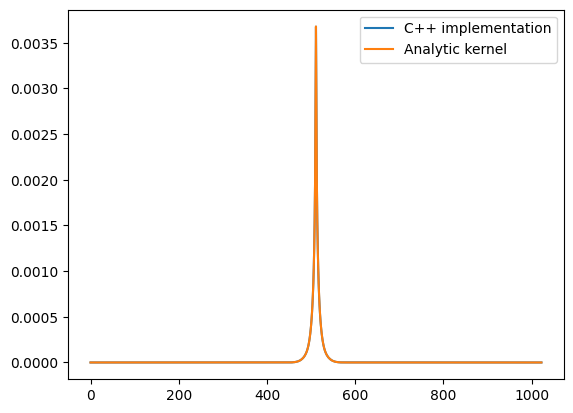

PyObject <matplotlib.legend.Legend object at 0x000000006E4FCA90>

In [56]:
K = readdlm("..//source//kernel.csv", ',');
N=1024
iS = 1
L = 20
Px = N÷2
Py = N÷2
eK = getSpatialKernel(A[iS:end] ,Sx[iS:end],Sy[iS:end],0,N, Px, Py);
py.plot(K[Px+1,2:end])
py.plot(eK[Px,1:end-1])
py.legend(["C++ implementation", "Analytic kernel"])